In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
import pandas as pd
import time
from numpy import linalg as LA
import pickle
import ray

In [2]:
from sconce.utils import cart2sph, sph2cart, CirSphSampling
from sconce.EucSCMS import KDE, SCMSLog
from sconce.DirSCMS import DirKDE, DirSCMSLog

### Simulate a dataset with 2000 noisy observations around a cross-shaped filament at the North pole

In [3]:
np.random.seed(123)  # Set an arbitrary seed for reproducibility
# Sampling the points on a circle that crosses through the north and south poles
cir_samp1 = CirSphSampling(1000, lat_c=0, lon_range=[-30,30], sigma=0.05, pv_ax=np.array([1,0,0]))
cir_samp2 = CirSphSampling(1000, lat_c=0, lon_range=[70,110], sigma=0.05, pv_ax=np.array([0,1,0]))
cir_samp = np.concatenate([cir_samp1, cir_samp2], axis=0)

qry_pt1 = CirSphSampling(2000, lat_c=0, lon_range=[-30,30], sigma=0.1, pv_ax=np.array([1,0,0]))
qry_pt2 = CirSphSampling(2000, lat_c=0, lon_range=[70,110], sigma=0.1, pv_ax=np.array([0,1,0]))
qry_pt = np.concatenate([qry_pt1, qry_pt2], axis=0)

true_cur1 = CirSphSampling(1000, lat_c=0, lon_range=[-30,30], sigma=0, pv_ax=np.array([1,0,0]))
true_cur2 = CirSphSampling(1000, lat_c=0, lon_range=[70,110], sigma=0, pv_ax=np.array([0,1,0]))
true_cur = np.concatenate([true_cur1, true_cur2], axis=0)

lon_c, lat_c, r = cart2sph(*cir_samp.T)
cir_samp_ang = np.concatenate((lon_c.reshape(len(lon_c),1), 
                               lat_c.reshape(len(lat_c),1)), axis=1)
lon_q, lat_q, r = cart2sph(*cir_samp.T)
qry_pt_ang = np.concatenate((lon_q.reshape(len(lon_q),1), 
                             lat_q.reshape(len(lat_q),1)), axis=1)
lon_t, lat_t, r = cart2sph(*true_cur.T)
true_cur_ang = np.concatenate((lon_t.reshape(len(lon_t),1), 
                               lat_t.reshape(len(lat_t),1)), axis=1)

In [4]:
cir_samp_df = pd.DataFrame(cir_samp_ang)
cir_samp_df.columns = ['RA', 'DEC']
cir_samp_df.to_csv('./Data_Outputs/Simulated_Data/circular_example.csv', index=False)

The current bandwidth is 0.051907033924410595.



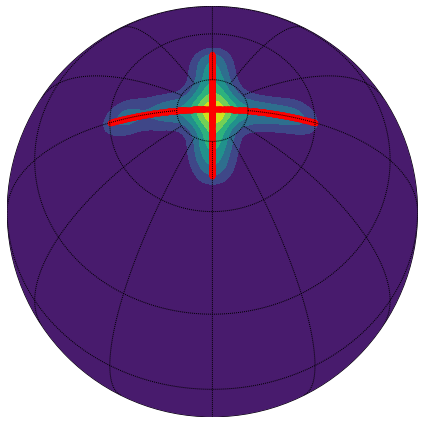

In [5]:
nrows, ncols = (90, 180)
lon, lat = np.meshgrid(np.linspace(-180, 180, ncols), 
                       np.linspace(-90, 90, nrows))
xg, yg, zg = sph2cart(lon, lat)
query_points = np.concatenate((xg.reshape(nrows*ncols, 1), 
                               yg.reshape(nrows*ncols, 1),
                               zg.reshape(nrows*ncols, 1)), axis=1)
d_hat_Dir = DirKDE(query_points, cir_samp, h=None).reshape(nrows, ncols)

plt.rcParams.update({'font.size': 13})  # Change the font sizes of ouput figures
fig = plt.figure(figsize=(6,6))
lon_t, lat_t, r = cart2sph(*true_cur.T)
# Set up map projection
m1 = Basemap(projection='ortho', lat_0=60, lon_0=0)
# m1 = Basemap(projection='hammer', llcrnrlon=-180, urcrnrlon=180,
#                  llcrnrlat=-90, urcrnrlat=90, resolution='c', lon_0=0)
# Draw lat/lon grid lines every 30 degrees.
m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 30))
# Compute native map projection coordinates of lat/lon grid.
x, y = m1(lon, lat)
x_t, y_t = m1(lon_t, lat_t)
# Contour plots over the map.
cs = m1.contourf(x, y, d_hat_Dir)
cs = m1.scatter(x_t, y_t, color='red', s=20, alpha=1, 
               label='True filaments')
fig.tight_layout()
plt.show()

### Apply the standard SCMS and our DirSCMS algorithms to the simulated dataset

In [6]:
bw_Dir = None
bw_Eu = None

d_Dir_dat = DirKDE(cir_samp, cir_samp, h=None)


## Estimate the directional and Euclidean densities on query points
nrows, ncols = (90, 180)
lon, lat = np.meshgrid(np.linspace(-180, 180, ncols), 
                       np.linspace(-90, 90, nrows))
xg, yg, zg = sph2cart(lon, lat)
query_points = np.concatenate((xg.reshape(nrows*ncols, 1), 
                               yg.reshape(nrows*ncols, 1),
                               zg.reshape(nrows*ncols, 1)), axis=1)
d_hat_Dir = DirKDE(query_points, cir_samp, h=bw_Dir).reshape(nrows, ncols)

query_points_ang = np.concatenate((lon.reshape(nrows*ncols, 1), 
                                   lat.reshape(nrows*ncols, 1)), axis=1)
d_hat_Eu = KDE(query_points_ang, cir_samp_ang, h=bw_Eu).reshape(nrows, ncols)

## Apply the directional and Euclidean SCMS algorithms
SCMS_Dir_log = DirSCMSLog(qry_pt, cir_samp, d=1, h=bw_Dir, 
                               eps=1e-7, max_iter=5000)
Dir_ridge_log = SCMS_Dir_log[:,:,SCMS_Dir_log.shape[2]-1]

SCMS_Eu_log = SCMSLog(qry_pt_ang, cir_samp_ang, d=1, h=bw_Eu, 
                           eps=1e-7, max_iter=5000)
Eu_ridge_log = SCMS_Eu_log[:,:,SCMS_Eu_log.shape[2]-1]

The current bandwidth is 0.051907033924410595.

The current bandwidth is 0.051907033924410595.

The current bandwidth is 15.66840839630243.

The current bandwidth is 0.051907033924410595.

The directional SCMS algorithm converges in 67steps!
The current bandwidth is 15.66840839630243.

The SCMS algorithm converges in 12steps!


#### Post-cleaning and visualizing the estimated filaments from the standard SCMS and our DirSCMS algorithms

In [7]:
import healpy as hp

def Mask_Filter(gal_RAs, gal_DECs, fil_RAs, fil_DECs, threshold=10, n_neigh=2, final_nside=256):
    nside = 32
    ## hp.nside2npix(nside) is equal to 12*nside**2
    healpix = np.zeros(hp.nside2npix(nside))
    gal_pix = hp.ang2pix(nside, theta=gal_RAs, phi=gal_DECs, lonlat=True)
    pix_ind, obs_cnt = np.unique(gal_pix, return_counts=True)
    healpix[pix_ind] = obs_cnt
    isolon, isolat = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))[healpix > threshold], lonlat=True)
    
    # Set up the pixels and find their neighbors after thresholding
    nside_ne = 128
    healpix_ne = np.zeros(hp.nside2npix(nside_ne))
    ne_pix = hp.ang2pix(nside_ne, theta=isolon, phi=isolat, lonlat=True)
    for _ in range(n_neigh):
        ne_pix = np.unique(hp.get_all_neighbours(nside_ne, ne_pix))
    healpix_ne[ne_pix] = 1.
    healpix_ne = hp.ud_grade(healpix_ne, final_nside)
    
    fila_pix = hp.ang2pix(final_nside, theta=fil_RAs, phi=fil_DECs, lonlat=True)
    return healpix_ne, fila_pix

In [8]:
# Post-cleaning the filaments
lon_f, lat_f, R = cart2sph(*Dir_ridge_log.T)
mask_pix_Dir, fil_pix_Dir = Mask_Filter(gal_RAs=cir_samp_ang[:,0], gal_DECs=cir_samp_ang[:,1], 
                                        fil_RAs=lon_f, fil_DECs=lat_f, threshold=1, 
                                        n_neigh=1, final_nside=32)
Dir_ridge_log1 = Dir_ridge_log[mask_pix_Dir[fil_pix_Dir] != 0]


mask_pix_Eu, fil_pix_Eu = Mask_Filter(gal_RAs=cir_samp_ang[:,0], gal_DECs=cir_samp_ang[:,1], 
                                        fil_RAs=Eu_ridge_log[:,0], fil_DECs=Eu_ridge_log[:,1], threshold=1, 
                                        n_neigh=1, final_nside=32)
Eu_ridge_log1 = Eu_ridge_log[mask_pix_Eu[fil_pix_Eu] != 0]

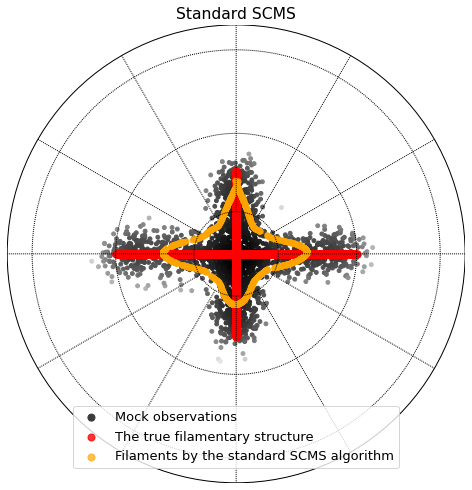

In [9]:
plt.rcParams.update({'font.size': 13})  # Change the font sizes of ouput figures
fig = plt.figure(figsize=(7,7))
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_c, lat_c, r = cart2sph(*cir_samp.T)
lon_r_Eu = Eu_ridge_log1[:,0]
lat_r_Eu = Eu_ridge_log1[:,1]
# Set up map projection
m1 = Basemap(projection='nsper',lon_0=0,lat_0=90, satellite_height=1e8)
# Draw lat/lon grid lines every 30 degrees.
# m1.drawmeridians(np.arange(-180, 180, 30), labels=[True,False,True,False])
# m1.drawparallels(np.arange(-90, 90, 30), labels=[False,True,True,False])
m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 30))
# Compute native map projection coordinates of lat/lon grid.
x, y = m1(lon_c, lat_c)
x_t, y_t = m1(lon_t, lat_t)
x_Eu, y_Eu = m1(lon_r_Eu, lat_r_Eu)
# x_Dir, y_Dir = m1(lon_r_Dir, lat_r_Dir)
# Scatter plots over the map.
cs = m1.scatter(x, y, c=1/(d_Dir_dat)**(1/100), s=15, cmap='gray', label='Mock observations')
# cs = m1.scatter(x_Eu, y_Eu, color='skyblue', s=(1e4)*unc_Eu1/180*np.pi, alpha=0.4)
cs = m1.scatter(x_t, y_t, color='red', s=50, alpha=0.8, label='The true filamentary structure')
cs = m1.scatter(x_Eu, y_Eu, color='orange', s=25, alpha=0.7, 
                label='Filaments by the standard SCMS algorithm')
# cs = m1.scatter(x_Eu, y_Eu, c=unc_Eu1, s=30, cmap='YlGn')
# cs = m1.scatter(x_Eu, y_Eu, c=unc_Eu1, s=30, cmap='winter')

lgnd = plt.legend(loc='center', bbox_to_anchor=(0.5, 0.1), numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]

# plt.colorbar(label='Uncertainty measures for filaments [deg]', fraction=0.04, pad=0.1)
plt.title('Standard SCMS')
fig.tight_layout()
plt.savefig('./Figures/EuSCMS_sim.jpg', bbox_inches="tight", dpi=150)
# plt.show()

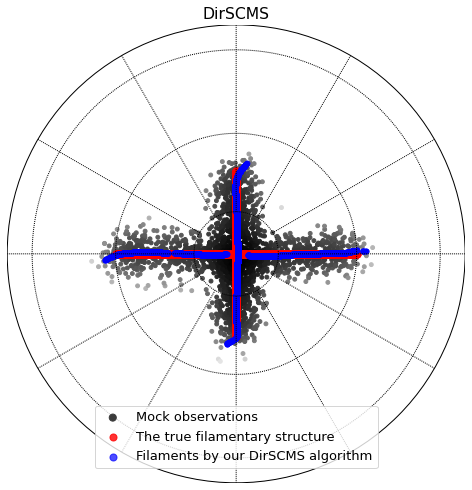

In [10]:
fig = plt.figure(figsize=(7,7))
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_c, lat_c, r = cart2sph(*cir_samp.T)
lon_r_Dir, lat_r_Dir, r = cart2sph(*Dir_ridge_log1.T)
# Set up map projection
# m1 = Basemap(projection='ortho', lat_0=60, lon_0=0)
m1 = Basemap(projection='nsper',lon_0=0,lat_0=90, satellite_height=1e8)
# Draw lat/lon grid lines every 30 degrees.
m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 30))
# Compute native map projection coordinates of lat/lon grid.
x, y = m1(lon_c, lat_c)
x_t, y_t = m1(lon_t, lat_t)
x_Eu, y_Eu = m1(lon_r_Eu, lat_r_Eu)
x_Dir, y_Dir = m1(lon_r_Dir, lat_r_Dir)
# Scatter plots over the map.
cs = m1.scatter(x, y, c=1/(d_Dir_dat)**(1/100), s=15, cmap='gray', label='Mock observations')
cs = m1.scatter(x_t, y_t, color='red', s=50, alpha=0.8, label='The true filamentary structure')
cs = m1.scatter(x_Dir, y_Dir, color='blue', s=25, alpha=0.7, label='Filaments by our DirSCMS algorithm')
# cs = m1.scatter(x_Dir, y_Dir, c=unc_Dir1*180/np.pi, s=30, cmap='winter')

lgnd = plt.legend(loc='center', bbox_to_anchor=(0.5, 0.1), numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]

# plt.colorbar(label='Uncertainty measures for filaments [deg]', fraction=0.04, pad=0.1)
plt.title('DirSCMS')
fig.tight_layout()
plt.savefig('./Figures/DirSCMS_sim.jpg', bbox_inches="tight", dpi=150)
# plt.show()

We vary the center of the true cross-shaped filament and investigate how the estimation bias of the standard SCMS and our DirSCMS algorithms would change with respect to declination values of the input observations.

In [11]:
def ProjDist_Dir(x, Fila):
    x = x.values
    if np.isnan(np.arccos(np.dot(Fila, x))).any():
        print(x)
    return np.min(np.arccos(np.dot(Fila, x)))

In [ ]:
### Warnings: this chunk of code takes more than 2 hours to execute!! One can choose to 
### load our pre-computed results instead.

lat_deg = np.linspace(0, 90, 10)
np.random.seed(123)  # Set an arbitrary seed for reproducibility
B = 20
Eu_err = np.zeros((B, 10))
Dir_err = np.zeros((B, 10))
for i in range(len(lat_deg)):
    print(i)
    for b in range(B):
        # Sampling the points on a circle that crosses through the north and south poles
        cir_samp1 = CirSphSampling(1000, lat_c=0, lon_range=[-30,30], sigma=0.05, pv_ax=np.array([1,0,0]))
        cir_samp2 = CirSphSampling(1000, lat_c=0, lon_range=[70,110], sigma=0.05, pv_ax=np.array([0,1,0]))
        cir_samp = np.concatenate([cir_samp1, cir_samp2], axis=0)
        ## Rotate the data samples accordingly
        pv_ax = np.array([[0,0,1]])
        gal_c = np.array(sph2cart(0, lat_deg[i])).reshape(1, 3)
        R_mat = 2*np.dot(pv_ax.T + gal_c.T, pv_ax + gal_c)/np.sum((gal_c+pv_ax)**2, axis=1) - np.identity(3)
        cir_samp = np.dot(R_mat, cir_samp.T).T
        true_cur1 = CirSphSampling(1000, lat_c=0, lon_range=[-30,30], sigma=0, pv_ax=np.array([1,0,0]))
        true_cur2 = CirSphSampling(1000, lat_c=0, lon_range=[70,110], sigma=0, pv_ax=np.array([0,1,0]))
        true_cur = np.concatenate([true_cur1, true_cur2], axis=0)
        true_cur = np.dot(R_mat, true_cur.T).T
        
        lon_c, lat_c, r = cart2sph(*cir_samp.T)
        cir_samp_ang = np.concatenate((lon_c.reshape(len(lon_c),1), 
                                       lat_c.reshape(len(lat_c),1)), axis=1)
        bw_Dir = None
        bw_Eu = None
        
        ## Estimate the directional and Euclidean densities on query points
        nrows, ncols = (90, 180)
        lon, lat = np.meshgrid(np.linspace(-180, 180, ncols), 
                               np.linspace(-90, 90, nrows))
        xg, yg, zg = sph2cart(lon, lat)
        query_points = np.concatenate((xg.reshape(nrows*ncols, 1), 
                                       yg.reshape(nrows*ncols, 1),
                                       zg.reshape(nrows*ncols, 1)), axis=1)
        d_hat_Dir = DirKDE(query_points, cir_samp, h=bw_Dir).reshape(nrows, ncols)
        
        query_points_ang = np.concatenate((lon.reshape(nrows*ncols, 1), 
                                           lat.reshape(nrows*ncols, 1)), axis=1)
        d_hat_Eu = KDE(query_points_ang, cir_samp_ang, h=bw_Eu).reshape(nrows, ncols)
        ## Apply the directional and Euclidean SCMS algorithms
        SCMS_Dir_log = DirSCMSLog(cir_samp, cir_samp, d=1, h=bw_Dir, eps=1e-7, max_iter=5000)
        Dir_ridge_log = SCMS_Dir_log[:,:,SCMS_Dir_log.shape[2]-1]
        
        SCMS_Eu_log = SCMSLog(cir_samp_ang, cir_samp_ang, d=1, h=bw_Eu, eps=1e-7, max_iter=5000)
        Eu_ridge_log = SCMS_Eu_log[:,:,SCMS_Eu_log.shape[2]-1]
    
        xg, yg, zg = sph2cart(Eu_ridge_log[:,0], Eu_ridge_log[:,1])
        Eu_ridge_log_cart = np.concatenate((xg.reshape(-1, 1), 
                                            yg.reshape(-1, 1),
                                            zg.reshape(-1, 1)), axis=1)
        Dir_err[b, i] = np.mean(pd.DataFrame(Dir_ridge_log).apply(lambda x: ProjDist_Dir(x, Fila=true_cur), axis=1))*180/np.pi
        Eu_err[b, i] = np.mean(pd.DataFrame(Eu_ridge_log_cart).apply(lambda x: ProjDist_Dir(x, Fila=true_cur), axis=1))*180/np.pi
        
with open("./Data_Outputs/Simulated_Data/DirEuSCMS_err_compare.dat", "wb") as file:
    pickle.dump([Dir_err, Eu_err], file)

In [12]:
## Load our pre-computed distance error distributions 
with open("./Data_Outputs/Simulated_Data/DirEuSCMS_err_compare.dat", "rb") as file:
    Dir_err, Eu_err = pickle.load(file)
lat_deg = np.linspace(0, 90, 10)

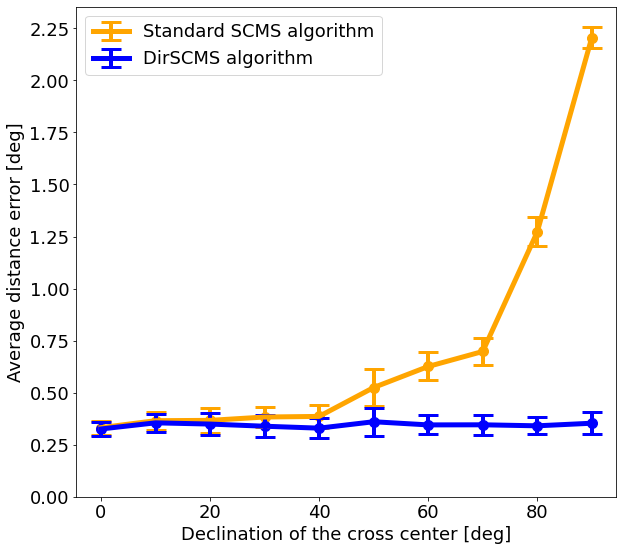

In [13]:
plt.rcParams.update({'font.size': 18})  # Change the font sizes of ouput figures
fig = plt.figure(figsize=(9,8))
plt.scatter(lat_deg, np.mean(Eu_err, axis=0), color='orange', s=100)
plt.scatter(lat_deg, np.mean(Dir_err, axis=0), color='blue', s=100)
(_, caps, _) = plt.errorbar(lat_deg, np.mean(Eu_err, axis=0), yerr=np.std(Eu_err, axis=0), linewidth=5,
             capsize=10, elinewidth=4, color='orange', label='Standard SCMS algorithm')
for cap in caps:
    cap.set_markeredgewidth(3)
(_, caps, _) = plt.errorbar(lat_deg, np.mean(Dir_err, axis=0), yerr=np.std(Dir_err, axis=0), linewidth=5,
             capsize=10, elinewidth=4, color='blue', label='DirSCMS algorithm')
for cap in caps:
    cap.set_markeredgewidth(3)
plt.xlabel('Declination of the cross center [deg]')
plt.ylabel('Average distance error [deg]')
# plt.xticks(np.linspace(45, 90, 10))
plt.yticks(np.linspace(0, 2.25, 10))
plt.legend()
plt.tight_layout()
plt.savefig('./Figures/EuDirErr_comp.pdf', bbox_inches="tight")

### Apply the "dredge" (SCMS with haverside formula) to the simulated dataset

In [14]:
from dredge import filaments

dredge_ridge = filaments(coordinates=np.radians(cir_samp_ang[:,::-1]), neighbors=20, bandwidth=None, convergence=1e-7, 
                         percentage=None, mesh=np.radians(cir_samp_ang[:,::-1]))

Input parameters valid!

Preparing for iterations ...

Automatically computed bandwidth: 0.022336

Iteration 1 ...
Iteration 2 ...
Iteration 3 ...
Iteration 4 ...
Iteration 5 ...
Iteration 6 ...
Iteration 7 ...
Iteration 8 ...
Iteration 9 ...
Iteration 10 ...
Iteration 11 ...
Iteration 12 ...
Iteration 13 ...
Iteration 14 ...
Iteration 15 ...
Iteration 16 ...
Iteration 17 ...
Iteration 18 ...
Iteration 19 ...
Iteration 20 ...
Iteration 21 ...
Iteration 22 ...
Iteration 23 ...
Iteration 24 ...
Iteration 25 ...
Iteration 26 ...
Iteration 27 ...
Iteration 28 ...
Iteration 29 ...
Iteration 30 ...
Iteration 31 ...
Iteration 32 ...
Iteration 33 ...
Iteration 34 ...
Iteration 35 ...
Iteration 36 ...
Iteration 37 ...
Iteration 38 ...
Iteration 39 ...
Iteration 40 ...
Iteration 41 ...
Iteration 42 ...
Iteration 43 ...
Iteration 44 ...
Iteration 45 ...
Iteration 46 ...
Iteration 47 ...
Iteration 48 ...
Iteration 49 ...
Iteration 50 ...
Iteration 51 ...
Iteration 52 ...
Iteration 53 ...
Iteration

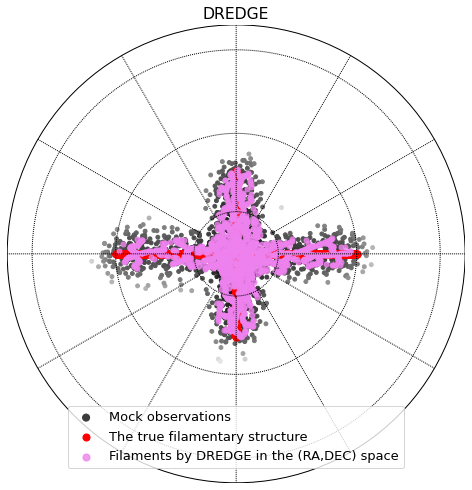

In [15]:
plt.rcParams.update({'font.size': 13})  # Change the font sizes of ouput figures
mask_pix_dredge, fil_pix_dredge = Mask_Filter(gal_RAs=cir_samp_ang[:,0], gal_DECs=cir_samp_ang[:,1], 
                                      fil_RAs=dredge_ridge[:,1]/np.pi*180, fil_DECs=dredge_ridge[:,0]/np.pi*180, 
                                      threshold=1, n_neigh=1, final_nside=32)
dredge_ridge1 = dredge_ridge[mask_pix_dredge[fil_pix_dredge] != 0]


fig = plt.figure(figsize=(7,7))
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_c, lat_c, r = cart2sph(*cir_samp.T)
lon_ang = dredge_ridge1[:,1]/np.pi*180
lat_ang = dredge_ridge1[:,0]/np.pi*180
# Set up map projection
# m1 = Basemap(projection='ortho', lat_0=60, lon_0=0)
m1 = Basemap(projection='nsper',lon_0=0,lat_0=90, satellite_height=1e8)
# Draw lat/lon grid lines every 30 degrees.
m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 30))
# Compute native map projection coordinates of lat/lon grid.
x, y = m1(lon_c, lat_c)
x_t, y_t = m1(lon_t, lat_t)
x_ang, y_ang = m1(lon_ang, lat_ang)
# Scatter plots over the map.
cs = m1.scatter(x, y, c=1/(d_Dir_dat)**(1/100), s=15, cmap='gray', label='Mock observations')
cs = m1.scatter(x_t, y_t, color='red', s=50, alpha=1, 
               label='The true filamentary structure')
cs = m1.scatter(x_ang, y_ang, color='violet', s=25, alpha=0.8, 
                label='Filaments by DREDGE in the (RA,DEC) space')
# cs = m1.scatter(x_ang, y_ang, c=unc_ang1, s=30, cmap='YlGn')

lgnd = plt.legend(loc='center', bbox_to_anchor=(0.5, 0.1), numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
plt.title('DREDGE')
plt.tight_layout()
# plt.colorbar(label='Uncertainty measures for filaments [deg]', fraction=0.04, pad=0.1)
# plt.show()
plt.savefig('./Figures/dredge_result.jpg', bbox_inches="tight", dpi=150)

### Results from the SCMS algorithm with HEALPix applied to the simulated dataset

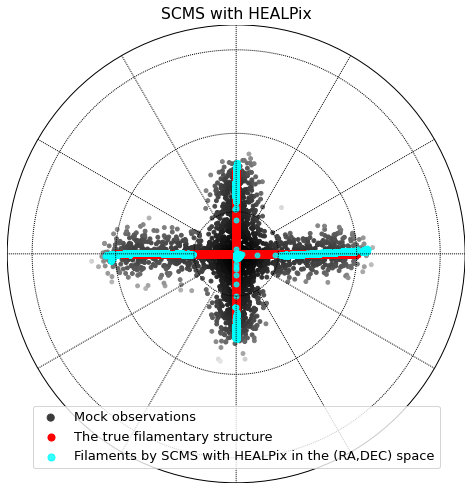

In [16]:
healpy_fila = pd.read_csv('./Data_Outputs/Simulated_Data/SCMS_healpy_test.csv')
healpy_fila.columns = ['RA', 'DEC']
mask_pix_hy, fil_pix_hy = Mask_Filter(gal_RAs=cir_samp_ang[:,0], gal_DECs=cir_samp_ang[:,1], 
                                      fil_RAs=healpy_fila['RA'].values, fil_DECs=healpy_fila['DEC'].values, 
                                      threshold=1, n_neigh=1, final_nside=32)
healpy_fila1 = healpy_fila[mask_pix_hy[fil_pix_hy] != 0]


plt.rcParams.update({'font.size': 13})  # Change the font sizes of ouput figures
fig = plt.figure(figsize=(7,7))
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_c, lat_c, r = cart2sph(*cir_samp.T)
lon_ang = healpy_fila1['RA']
lat_ang = healpy_fila1['DEC']
# Set up map projection
# m1 = Basemap(projection='ortho', lat_0=60, lon_0=0)
m1 = Basemap(projection='nsper',lon_0=0,lat_0=90, satellite_height=1e8)
# Draw lat/lon grid lines every 30 degrees.
m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 30))
# Compute native map projection coordinates of lat/lon grid.
x, y = m1(lon_c, lat_c)
x_t, y_t = m1(lon_t, lat_t)
x_ang, y_ang = m1(lon_ang, lat_ang)
# Scatter plots over the map.
cs = m1.scatter(x, y, c=1/(d_Dir_dat)**(1/100), s=15, cmap='gray', label='Mock observations')
cs = m1.scatter(x_t, y_t, color='red', s=50, alpha=1, 
               label='The true filamentary structure')
cs = m1.scatter(x_ang, y_ang, color='cyan', s=25, alpha=0.8, 
                label='Filaments by SCMS with HEALPix in the (RA,DEC) space')
# cs = m1.scatter(x_ang, y_ang, c=unc_ang1, s=30, cmap='YlGn')

lgnd = plt.legend(loc='center', bbox_to_anchor=(0.5, 0.1), numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
plt.title('SCMS with HEALPix')
plt.tight_layout()
# plt.colorbar(label='Uncertainty measures for filaments [deg]', fraction=0.04, pad=0.1)
# plt.show()
plt.savefig('./Figures/SCMS_healpy_result.jpg', bbox_inches="tight", dpi=150)

### Run the DisPerSE on the simulated dataset

In [17]:
# Prepare the data format of which the DisPerSE code can read
from astropy.io import ascii
from astropy.table import Table

dat_ang = pd.DataFrame(cir_samp_ang)
dat_ang.columns = ['px', 'py']
dat_ang = Table.from_pandas(dat_ang)
# Output the file for which the DisPerSE code can read.
ascii.write(dat_ang, './Data_Outputs/Simulated_Data/cir_samp_ang.survey_ascii', overwrite=True, comment=False)

dat_cart = pd.DataFrame(cir_samp)
dat_cart.columns = ['px', 'py', 'pz']
dat_cart = Table.from_pandas(dat_cart)
# Output the file for which the DisPerSE code can read.
ascii.write(dat_cart, './Data_Outputs/Simulated_Data/cir_samp.survey_ascii', overwrite=True, comment=False)

In [18]:
!../../disperse/bin/delaunay_2D ./Data_Outputs/Simulated_Data/cir_samp_ang.survey_ascii \
-outName ./Data_Outputs/Simulated_Data/cir_samp_ang -btype smooth


reading ./Data_Outputs/Simulated_Data/cir_samp_ang.survey_ascii (ASCII) ... done. (2000 lines)
Margin set to 0.0366846 (actual size is ~13.2523).
Tesselating 2000 particles (2D) ... (+0 in boundary) done. (0.00s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (66 guards):  tesselation ...  generating ... cleaning up ... done. (+1049 particles)
Adding 1049 particles ... done.
Computing density ... done.
All done in 0.02 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './Data_Outputs/Simulated_Data/cir_samp_ang.NDnet'.
All done.

Network was saved as : ./Data_Outputs/Simulated_Data/cir_samp_ang.NDnet
   comment: 'No cosmological conversion.'
   2D-Network has 2305 vertices.
   periodicity: non-periodic.
   Available faces: 6611 1-F, 4307 2-F.
   Bounding box: x0=[-180.613,51.6792],
                 delta=[361.25,38.8925].
   Available fields: 'field_value'(0), 'log_field_value'(0), 'mass'(0)
                     

In [19]:
!../../disperse/bin/mse ./Data_Outputs/Simulated_Data/cir_samp_ang.NDnet \
-outName ./Data_Outputs/Simulated_Data/cir_samp_ang -periodicity 0 -nsig 6 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Simulated_Data/cir_samp_ang.NDnet'.
Loading 2D network from file "./Data_Outputs/Simulated_Data/cir_samp_ang.NDnet" ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (350 1-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 13223 cells:
   Identifying (1,2)-cell pairs:
      Sorting 6611 1-cells (asc.) ... done.
      Computing MST ... (components) done.(130/4307 comp.)
      Computing discrete Gradient (130 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Computing MST ... (components) done.(552/2305 comp.)
      Computing discrete Gradient (552 comp.) ... done.
   Critical cells : 552(+0) 0-cells, 681(+681) 1-cells, 130(+0) 2-cells.
Computing discrete Morse-Smale complex: 
    1363 critical points: 130 min, 681 s1, 552 max.
    * minima: SKIPPED.
 

In [20]:
!../../disperse/bin/skelconv ./Data_Outputs/Simulated_Data/cir_samp_ang_s6.up.NDskl \
-outName ./Data_Outputs/Simulated_Data/cir_samp_ang_s6.up -smooth 5 -breakdown -assemble 75 -to NDskl_ascii

Will read skeleton from file './Data_Outputs/Simulated_Data/cir_samp_ang_s6.up.NDskl'.
Loading 2D skeleton from file ./Data_Outputs/Simulated_Data/cir_samp_ang_s6.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 59(+18) nodes and 663(-1912) segments.
Assembling skeleton ... done. (found 19 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 38(-21) nodes and 663(0) segments left.
Will write skeleton to file './Data_Outputs/Simulated_Data/cir_samp_ang_s6.up.S005.BRK.ASMB.a.NDskl'.
Saving 2D skeleton to ASCII file ./Data_Outputs/Simulated_Data/cir_samp_ang_s6.up.S005.BRK.ASMB.a.NDskl ... done.


In [21]:
!../../disperse/bin/delaunay_3D ./Data_Outputs/Simulated_Data/cir_samp.survey_ascii \
-outName ./Data_Outputs/Simulated_Data/cir_samp -btype mirror


reading ./Data_Outputs/Simulated_Data/cir_samp.survey_ascii (ASCII) ... done. (2000 lines)
Margin set to 0.203278 (actual size is ~0.250992).
Tesselating 2000 particles (3D) ... (+8836 in boundary)
         Some points have identical coordinates !
 done. (0.16s elapsed)
Identifying boundaries ... done.
Adding 23612 guard particles ... 
         Some points have identical coordinates !
 done. (0.50s elapsed)
Identifying boundaries ... done.
Computing density ... done.
All done in 0.56 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './Data_Outputs/Simulated_Data/cir_samp.NDnet'.
All done.

Network was saved as : ./Data_Outputs/Simulated_Data/cir_samp.NDnet
   comment: 'No cosmological conversion.'
   3D-Network has 6126 vertices.
   periodicity: non-periodic.
   Available faces: 38638 1-F, 62809 2-F, 24240 3-F.
   Bounding box: x0=[-0.424962,-0.613799,0.779621],
                 delta=[0.882045,1.23472,0.232295].
   Available fields: 'field_value'(0), 'log_f

In [22]:
!../../disperse/bin/mse ./Data_Outputs/Simulated_Data/cir_samp.NDnet \
-outName ./Data_Outputs/Simulated_Data/cir_samp -periodicity 0 -nsig 5.5 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Simulated_Data/cir_samp.NDnet'.
Loading 3D network from file "./Data_Outputs/Simulated_Data/cir_samp.NDnet" ... done.
Computing 3-faces lists for vertice ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (3970 2-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 131813 cells:
   Identifying (2,3)-cell pairs:
      Sorting 62809 2-cells (asc.) ... done.
      Computing MST ... (components) done.(0/24240 comp.)
      Computing discrete Gradient (0 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Sorting 38638 1-cells (desc.) ... done.
      Computing MST ... (components) done.(324/6126 comp.)
      Computing discrete Gradient (324 comp.) ... done.
   Identifying (1,2)-cell pairs:
      Computing saddle-saddle DG ... done.
   Critical cells : 324(+0) 0-

In [23]:
!../../disperse/bin/skelconv ./Data_Outputs/Simulated_Data/cir_samp_s5.5.up.NDskl \
-outName ./Data_Outputs/Simulated_Data/cir_samp_s5.5.up -smooth 5 -breakdown -assemble 75 -to NDskl_ascii

Will read skeleton from file './Data_Outputs/Simulated_Data/cir_samp_s5.5.up.NDskl'.
Loading 3D skeleton from file ./Data_Outputs/Simulated_Data/cir_samp_s5.5.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 111(+33) nodes and 688(-1631) segments.
Assembling skeleton ... done. (found 39 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 73(-38) nodes and 688(0) segments left.
Will write skeleton to file './Data_Outputs/Simulated_Data/cir_samp_s5.5.up.S005.BRK.ASMB.a.NDskl'.
Saving 3D skeleton to ASCII file ./Data_Outputs/Simulated_Data/cir_samp_s5.5.up.S005.BRK.ASMB.a.NDskl ... done.


In [24]:
## Helper function for processing the DisPerSE output
def read_skl(file, dim=3):
    i = 3
    line = 'start'
    while line != '[FILAMENTS]':
        line = np.loadtxt(file, skiprows=i, max_rows=1, usecols=0, dtype=str)
        i += 1
        
    n_fil = int(np.loadtxt(file, skiprows=i, max_rows=1, dtype=int))
    
    fil_id = np.zeros(0, dtype=int)
    fil_tracers = np.empty(shape=(0,dim), dtype=float)
    count = 1
    for j in range(n_fil):
        n_tracers = int(np.loadtxt(file, skiprows=i+1, max_rows=1, usecols=2, dtype=int))
        filament = np.loadtxt(file, skiprows=i+2, max_rows=n_tracers)
        fil_tracers = np.vstack([fil_tracers, filament])
        fil_id = np.append(fil_id, count*np.ones(n_tracers, dtype=int))
        count += 1
        i += n_tracers + 1
    
    return(n_fil, fil_id, fil_tracers)

In [25]:
disp_fil, fil_id, disp_web_ang = read_skl('./Data_Outputs/Simulated_Data/cir_samp_ang_s6.up.S005.BRK.ASMB.a.NDskl', 
                                          dim=2)
disp_fil, fil_id, disp_web_cart = read_skl('./Data_Outputs/Simulated_Data/cir_samp_s5.5.up.S005.BRK.ASMB.a.NDskl', 
                                           dim=3)

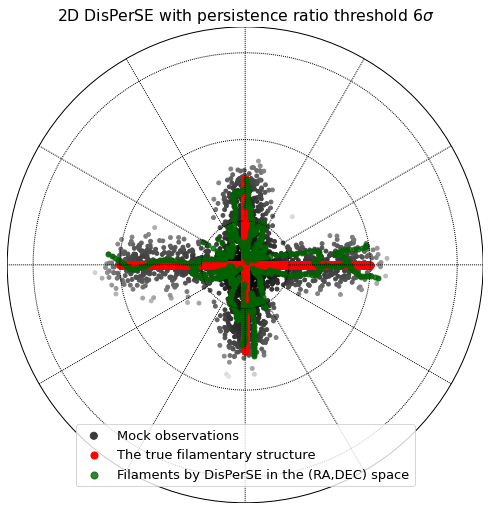

In [26]:
plt.rcParams.update({'font.size': 13})  # Change the font sizes of ouput figures

mask_pix_disp_ang, fil_pix_disp_ang = Mask_Filter(gal_RAs=cir_samp_ang[:,0], gal_DECs=cir_samp_ang[:,1], 
                                      fil_RAs=disp_web_ang[:,0], fil_DECs=disp_web_ang[:,1], 
                                      threshold=1, n_neigh=1, final_nside=32)
disp_web_ang1 = disp_web_ang[mask_pix_disp_ang[fil_pix_disp_ang] != 0]

fig = plt.figure(figsize=(7,7))
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_c, lat_c, r = cart2sph(*cir_samp.T)
lon_ang = disp_web_ang[:,0]
lat_ang = disp_web_ang[:,1]
# Set up map projection
# m1 = Basemap(projection='ortho', lat_0=60, lon_0=0)
m1 = Basemap(projection='nsper',lon_0=0,lat_0=90, satellite_height=1e8)
# Draw lat/lon grid lines every 30 degrees.
m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 30))
# Compute native map projection coordinates of lat/lon grid.
x, y = m1(lon_c, lat_c)
x_t, y_t = m1(lon_t, lat_t)
x_ang, y_ang = m1(lon_ang, lat_ang)
# Scatter plots over the map.
cs = m1.scatter(x, y, c=1/(d_Dir_dat)**(1/100), s=15, cmap='gray', label='Mock observations')
cs = m1.scatter(x_t, y_t, color='red', s=50, alpha=1, 
               label='The true filamentary structure')
cs = m1.scatter(x_ang, y_ang, color='darkgreen', s=25, alpha=0.8, 
                label='Filaments by DisPerSE in the (RA,DEC) space')
# cs = m1.scatter(x_ang, y_ang, c=unc_ang1, s=30, cmap='YlGn')

lgnd = plt.legend(loc='center', bbox_to_anchor=(0.5, 0.1), numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]

plt.tight_layout()
# plt.colorbar(label='Uncertainty measures for filaments [deg]', fraction=0.04, pad=0.1)
plt.title('2D DisPerSE with persistence ratio threshold $6\sigma$')
# plt.show()
plt.savefig('./Figures/disperse_ang_6sig.jpg', bbox_inches="tight", dpi=150)

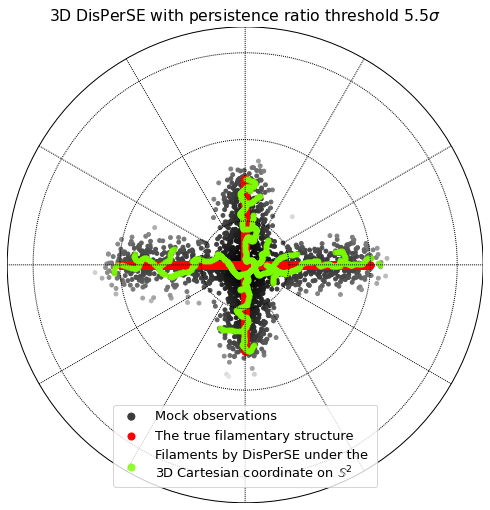

In [27]:
plt.rcParams.update({'font.size': 13})  # Change the font sizes of ouput figures
fig = plt.figure(figsize=(7,7))
lon_f, lat_f, R = cart2sph(*disp_web_cart.T)
dis_fila_cart = pd.DataFrame({'RA': lon_f, 'DEC': lat_f})
mask_pix_disp_cart, fil_pix_disp_cart = Mask_Filter(gal_RAs=cir_samp_ang[:,0], gal_DECs=cir_samp_ang[:,1], 
                                      fil_RAs=dis_fila_cart['RA'].values, fil_DECs=dis_fila_cart['DEC'].values, 
                                      threshold=1, n_neigh=1, final_nside=32)
dis_fila_cart1 = dis_fila_cart[mask_pix_disp_cart[fil_pix_disp_cart] != 0]


lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_c, lat_c, r = cart2sph(*cir_samp.T)
lon_cart = dis_fila_cart1['RA'].values
lat_cart = dis_fila_cart1['DEC'].values
# Set up map projection
# m1 = Basemap(projection='ortho', lat_0=60, lon_0=0)
m1 = Basemap(projection='nsper',lon_0=0,lat_0=90, satellite_height=1e8)
# Draw lat/lon grid lines every 30 degrees.
m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 30))
# Compute native map projection coordinates of lat/lon grid.
x, y = m1(lon_c, lat_c)
x_t, y_t = m1(lon_t, lat_t)
x_cart, y_cart = m1(lon_cart, lat_cart)
# Scatter plots over the map.
cs = m1.scatter(x, y, c=1/(d_Dir_dat)**(1/100), s=15, cmap='gray', label='Mock observations')
cs = m1.scatter(x_t, y_t, color='red', s=50, alpha=1, label='The true filamentary structure')
cs = m1.scatter(x_cart, y_cart, color='lawngreen', s=25, alpha=0.8, 
                label='Filaments by DisPerSE under the \n3D Cartesian coordinate on $\mathbb{S}^2$')
# cs = m1.scatter(x_cart, y_cart, c=unc_cart1*180/np.pi, s=30, cmap='winter')

lgnd = plt.legend(loc='center', bbox_to_anchor=(0.5, 0.12), numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]

plt.tight_layout()
# plt.colorbar(label='Uncertainty measures for filaments [deg]', fraction=0.04, pad=0.1)
plt.title('3D DisPerSE with persistence ratio threshold $5.5\sigma$')
# plt.show()
plt.savefig('./Figures/disperse_cart_5.5sig.jpg', bbox_inches="tight", dpi=150)

### Distance errors from the estimated filaments to the true one

In [28]:
def ProjDist_Dir(x, Fila):
    x = x.values
    if np.isnan(np.arccos(np.dot(Fila, x))).any():
        print(x)
    return np.min(np.arccos(np.dot(Fila, x)))

In [29]:
# Distance from the estimated filaments to the true one.

disp_fil, fil_id, disp_web_ang = read_skl('cir_samp_ang_s6.up.S005.BRK.ASMB.a.NDskl', dim=2)
mask_pix_disp_ang, fil_pix_disp_ang = Mask_Filter(gal_RAs=cir_samp_ang[:,0], gal_DECs=cir_samp_ang[:,1], 
                                      fil_RAs=disp_web_ang[:,0], fil_DECs=disp_web_ang[:,1], 
                                      threshold=1, n_neigh=1, final_nside=32)
disp_web_ang1 = disp_web_ang[mask_pix_disp_ang[fil_pix_disp_ang] != 0]

xg, yg, zg = sph2cart(disp_web_ang1[:,0], disp_web_ang1[:,1])
disp_web_ang_cart = np.concatenate((xg.reshape(-1, 1), 
                                    yg.reshape(-1, 1),
                                    zg.reshape(-1, 1)), axis=1)

disp_fil, fil_id, disp_web_cart = read_skl('cir_samp_s5.5.up.S005.BRK.ASMB.a.NDskl', dim=3)
lon_f, lat_f, R = cart2sph(*disp_web_cart.T)
dis_fila_cart = pd.DataFrame({'RA': lon_f, 'DEC': lat_f})
mask_pix_disp_cart, fil_pix_disp_cart = Mask_Filter(gal_RAs=cir_samp_ang[:,0], gal_DECs=cir_samp_ang[:,1], 
                                      fil_RAs=dis_fila_cart['RA'].values, fil_DECs=dis_fila_cart['DEC'].values, 
                                      threshold=1, n_neigh=1, final_nside=32)
disp_web_cart1 = disp_web_cart[mask_pix_disp_cart[fil_pix_disp_cart] != 0]

proj_disp_ang = pd.DataFrame(disp_web_ang_cart).apply(lambda x: ProjDist_Dir(x, Fila=true_cur), axis=1)*180/np.pi
proj_disp_cart = pd.DataFrame(disp_web_cart1).apply(lambda x: ProjDist_Dir(x, Fila=true_cur), axis=1)*180/np.pi


proj_DirSCMS = pd.DataFrame(Dir_ridge_log1).apply(lambda x: ProjDist_Dir(x, Fila=true_cur), axis=1)*180/np.pi
xg, yg, zg = sph2cart(Eu_ridge_log[:,0], Eu_ridge_log[:,1])
Eu_ridge_log_cart = np.concatenate((xg.reshape(-1, 1), 
                                    yg.reshape(-1, 1),
                                    zg.reshape(-1, 1)), axis=1)
proj_EuSCMS = pd.DataFrame(Eu_ridge_log_cart).apply(lambda x: ProjDist_Dir(x, Fila=true_cur), axis=1)*180/np.pi

xg, yg, zg = sph2cart(healpy_fila1['RA'].values, healpy_fila1['DEC'].values)
SCMS_hy_ridge_cart = np.concatenate((xg.reshape(-1, 1), 
                                    yg.reshape(-1, 1),
                                    zg.reshape(-1, 1)), axis=1)
proj_hySCMS = pd.DataFrame(SCMS_hy_ridge_cart).apply(lambda x: ProjDist_Dir(x, Fila=true_cur), axis=1)*180/np.pi

xg, yg, zg = sph2cart(dredge_ridge[:,1]/np.pi*180, dredge_ridge[:,0]/np.pi*180)
dredge_ridge_cart = np.concatenate((xg.reshape(-1, 1), 
                                    yg.reshape(-1, 1),
                                    zg.reshape(-1, 1)), axis=1)
proj_dredge = pd.DataFrame(dredge_ridge_cart).apply(lambda x: ProjDist_Dir(x, Fila=true_cur), axis=1)*180/np.pi

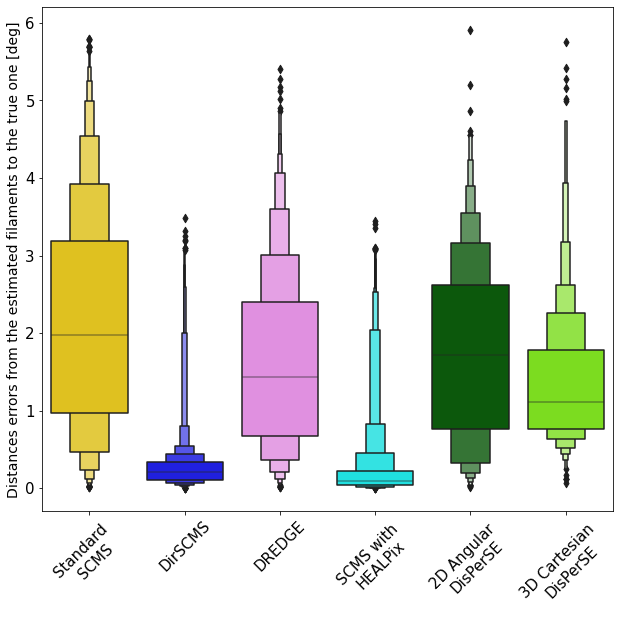

In [30]:
import seaborn as sns
plt.rcParams.update({'font.size': 15})  # Change the font sizes of ouput figures
plt.figure(figsize=(9,8))
# 'Distances error from estimated filaments to the true one [deg]'
gal_dist = pd.DataFrame({'Distances error [deg]': np.concatenate([proj_EuSCMS, proj_DirSCMS, proj_dredge, 
                                                                  proj_hySCMS, proj_disp_ang, proj_disp_cart]),
                         'Algorithms': np.concatenate([np.repeat('Standard \nSCMS', proj_EuSCMS.shape[0]), 
                                                       np.repeat('DirSCMS', proj_DirSCMS.shape[0]), 
                                                       np.repeat('DREDGE', proj_dredge.shape[0]),
                                                       np.repeat('SCMS with \nHEALPix', proj_hySCMS.shape[0]),
                                                      np.repeat('2D Angular \nDisPerSE', proj_disp_ang.shape[0]), 
                                                      np.repeat('3D Cartesian \nDisPerSE', proj_disp_cart.shape[0])])})
my_pal = {'Standard \nSCMS': 'gold', 'DREDGE': 'violet', 'SCMS with \nHEALPix': 'cyan',
          '2D Angular \nDisPerSE': 'darkgreen', '3D Cartesian \nDisPerSE': 'lawngreen', 'DirSCMS': 'blue'}
# sns.boxplot(y="Distances error [deg]", x="Algorithms", data=gal_dist, palette=my_pal, boxprops=dict(alpha=.8))
sns.boxenplot(y="Distances error [deg]", x="Algorithms", data=gal_dist, palette=my_pal)
plt.xlabel("", fontsize=15)
plt.ylabel("Distances errors from the estimated filaments to the true one [deg]", fontsize=14)
plt.tight_layout()
plt.xticks(rotation=45) # Rotates X-Axis Ticks by 45-degrees
# plt.show()
plt.savefig('./Figures/art_fila_comp.pdf', bbox_inches="tight")

### Distance from the true cross-shaped filament to the estimated ones

In [31]:
proj_disp_ang_tte = pd.DataFrame(true_cur).apply(lambda x: ProjDist_Dir(x, Fila=disp_web_ang_cart), axis=1)*180/np.pi
proj_disp_cart_tte = pd.DataFrame(true_cur).apply(lambda x: ProjDist_Dir(x, Fila=disp_web_cart1), axis=1)*180/np.pi

proj_DirSCMS_tte = pd.DataFrame(true_cur).apply(lambda x: ProjDist_Dir(x, Fila=Dir_ridge_log1), axis=1)*180/np.pi
proj_EuSCMS_tte = pd.DataFrame(true_cur).apply(lambda x: ProjDist_Dir(x, Fila=Eu_ridge_log_cart), axis=1)*180/np.pi
proj_hySCMS_tte = pd.DataFrame(true_cur).apply(lambda x: ProjDist_Dir(x, Fila=SCMS_hy_ridge_cart), axis=1)*180/np.pi
proj_dredge_tte = pd.DataFrame(true_cur).apply(lambda x: ProjDist_Dir(x, Fila=dredge_ridge_cart), axis=1)*180/np.pi

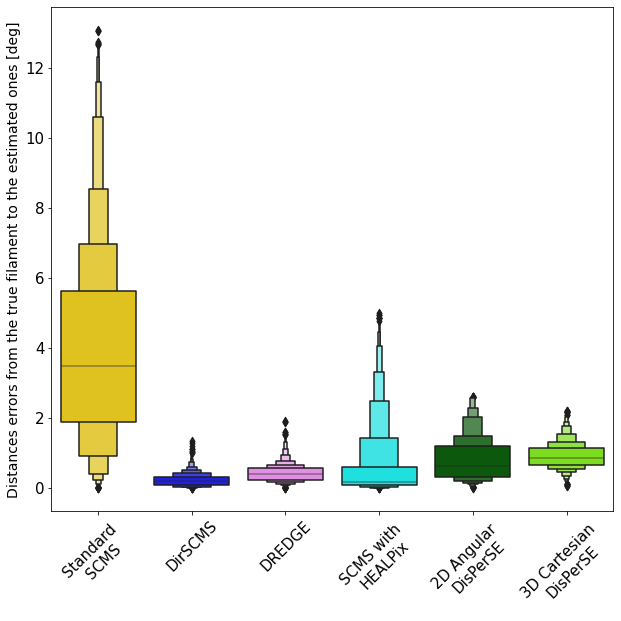

In [32]:
plt.rcParams.update({'font.size': 15})  # Change the font sizes of ouput figures
plt.figure(figsize=(9,8))
# 'Distances error from the true filamentary structure to the estimated ones [deg]'
gal_dist = pd.DataFrame({'Distances error [deg]': np.concatenate([proj_EuSCMS_tte, proj_DirSCMS_tte, proj_dredge_tte, 
                                                                  proj_hySCMS_tte, proj_disp_ang_tte, proj_disp_cart_tte]),
                         'Algorithms': np.concatenate([np.repeat('Standard \nSCMS', proj_EuSCMS_tte.shape[0]), 
                                                       np.repeat('DirSCMS', proj_DirSCMS_tte.shape[0]), 
                                                       np.repeat('DREDGE', proj_dredge_tte.shape[0]),
                                                       np.repeat('SCMS with \nHEALPix', proj_hySCMS_tte.shape[0]),
                                                      np.repeat('2D Angular \nDisPerSE', proj_disp_ang_tte.shape[0]), 
                                                      np.repeat('3D Cartesian \nDisPerSE', proj_disp_cart_tte.shape[0])])})
my_pal = {'Standard \nSCMS': 'gold', 'DREDGE': 'violet', 'SCMS with \nHEALPix': 'cyan',
          '2D Angular \nDisPerSE': 'darkgreen', '3D Cartesian \nDisPerSE': 'lawngreen', 'DirSCMS': 'blue'}
# sns.boxplot(y="Distances error [deg]", x="Algorithms", data=gal_dist, palette=my_pal, boxprops=dict(alpha=.8))
sns.boxenplot(y="Distances error [deg]", x="Algorithms", data=gal_dist, palette=my_pal)
plt.xlabel("", fontsize=15)
plt.ylabel("Distances errors from the true filament to the estimated ones [deg]", fontsize=14)
plt.tight_layout()
plt.xticks(rotation=45) # Rotates X-Axis Ticks by 45-degrees
# plt.show()
plt.savefig('./Figures/art_fila_comp_tte.pdf', bbox_inches="tight")

### Hausdorff distances between the estimated filaments and the true one

In [33]:
{'Standard SCMS': max(max(proj_EuSCMS), max(proj_EuSCMS_tte)), 
                          'DirSCMS': max(max(proj_DirSCMS), max(proj_DirSCMS_tte)), 
                          'DREDGE': max(max(proj_dredge), max(proj_dredge_tte)), 
                          'SCMS with HEALPix': max(max(proj_hySCMS), max(proj_hySCMS_tte)), 
                          '2D Angular DisPerSE': max(max(proj_disp_ang), max(proj_disp_ang)), 
                          '3D Cartesian DisPerSE': max(max(proj_disp_cart), max(proj_disp_cart))}

{'Standard SCMS': 13.078811585342399,
 'DirSCMS': 3.4860809494430276,
 'DREDGE': 5.407749107433445,
 'SCMS with HEALPix': 4.996924429752241,
 '2D Angular DisPerSE': 5.907362142803774,
 '3D Cartesian DisPerSE': 5.7538886623324}

In [34]:
print(np.mean(proj_hySCMS))
np.mean(proj_DirSCMS)

0.2604397076556598


0.2872968774639938

In [35]:
print(np.mean(proj_hySCMS_tte))
np.mean(proj_DirSCMS_tte)

0.5950553429110814


0.23520713516883723

In [36]:
print(np.median(proj_hySCMS_tte))
np.median(proj_DirSCMS_tte)

0.19272450779610312


0.20508552904544375